In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Deep_Neural_Network:

  def create(self,input_size,output_size,hidden_dims,output_type,initializer='random',
             seed=None,activation='relu',leaky_relu_slope=0.1):
    """
    The method to define the architecture of Deep Neural Network and initialize weights.

    Parameters:

    input_size(int)       :   No. of neurons in input layer.
    
    output_size(int)      :   No. of classes in classification task (2 in case of binary classification,
                              modify the dataset accordingly !)
                              (or) No. of Target variables in case of regression task.

    hidden_dims(int list) :   No. of neurons in hidden layers.

    output_type(string)   :   Type of task :
                              'classification'  :  Classification (discrete target).
                              'regression'      :  Regression (continuous target).

    initializer(string)   :   Weight initializer :
                              'random'  : Random initialization.
                              'xavier'  : Xavier initialization (preferred for tanh activation).
                              'he'      : He initialization (preferred for ReLU activation).

    seed(int)             :   NumPy seed for random initialization.

    activation(string)    :   Activation function for hidden layers. One of the following :
                              'linear'  : Linear activation.
                              'sigmoid' : Sigmoid activation.
                              'tanh'    : Hyberbolic tangent activation.
                              'relu'    : Rectified Linear Unit activation.
                              'lrelu'   : Leaky Rectified Linear Unit activation.

                              Activation function at output layer would be SoftMax for classification
                              and Linear for regression.

    leaky_relu_slope(int) :   Slope for Leaky ReLU activation.   

    """
    self.layer_dims=[input_size]+hidden_dims+[output_size]
    self.W = {}
    self.b = {}
    self.activation = activation
    self.leaky_relu_slope = leaky_relu_slope
    self.initializer = initializer
    self.output_type = output_type

    self.L = len(self.layer_dims)-1

    if seed != None:
      np.random.seed(seed)

    for i in range(self.L):
      self.W[i+1] = np.random.randn(self.layer_dims[i+1],self.layer_dims[i])
      self.b[i+1] = np.zeros((self.layer_dims[i+1],1))

    if self.initializer == 'xavier':
      for i in range(self.L):
        self.W[i+1] = self.W[i+1]*np.sqrt(1/(self.layer_dims[i]))

    elif self.initializer == 'he':
      for i in range(self.L):
        self.W[i+1] = self.W[i+1]*np.sqrt(2/(self.layer_dims[i]))



  def save_weights(self):
    """
    The method to save model weights.

    Returns :

    params(tuple)   : Tuple containing Model weights and biases in form of dictionaries.

    """
    return (self.W,self.b)

  

  def load_weights(self,params):
    """
    The method to load model weights.

    Parameters :

    params(tuple)   : Tuple containing Model weights and biases in form of dictionaries.

    """
    self.W = params[0]
    self.b = params[1]



  ### ACTIVATION FUNCTIONS AND THEIR GRADIENTS ###

  def linear(self,X):
    return X

  def linear_grad(self,X):
    return np.ones(shape=X.shape) 

  def sigmoid(self,X):
    return 1/(1+np.exp(-X))

  def sigmoid_grad(self,X):
    return self.sigmoid(X)*(1-self.sigmoid(X))

  def tanh(self,X):
    return np.tanh(X)

  def tanh_grad(self,X):
    return 1-((self.tanh(X))**2)

  def relu(self,X):
    return np.maximum(0,X)

  def relu_grad(self,X):
    return 1.0*(X>0)

  def lrelu(self,X):
    return np.where(X > 0, X, X * self.leaky_relu_slope)

  def lrelu_grad(self,X):
    return np.where(X > 0, 1, self.leaky_relu_slope)   

  def softmax(self,X):
    exps = np.exp(X-np.max(X))
    return exps/np.sum(exps,axis=0)



  def to_one_hot(self,X):
    """
    The method to convert SoftMax probabilities to label in one hot form.

    Parameters :

    X(NumPy 2D array of shape (output_size,m))  : Predicted SoftMax probabilities for batch of size m.

    Returns :

    X_one_hot(NumPy 2D array of shape (output_size,m)) : Predicted labels in one hot form for batch of 
                                                         size m.

    """
    a = np.argmax(X,axis=0)
    b = np.zeros((X.shape[0],a.size))
    b[a,np.arange(a.size)] = 1
    return b



  def accuracy(self,Y_pred,Y_true):
    """
    The method to calculate classification accuracy.

    Parameters :

    Y_pred(NumPy 2D array of shape (output_size,m))  : Predicted labels for batch of size m.
    
    Y_true(NumPy 2D array of shape (output_size,m))  : Actual labels for batch of size m.

    Returns :

    accuracy(float)   : Accuracy in range [0,1].

    """
    a = np.argmax(Y_pred,axis=0)
    b = np.argmax(Y_true,axis=0)

    correct = np.sum((a==b)*1)
    total = a.size

    return correct/total



  def forward_propagation(self,X,dropout=False):
    """
    The method to forward propagate input data through the network, and calculate activations of 
    each layer.

    Parameters :

    X(NumPy 2D array of shape (input_size,m))  : Input data for batch of size m.

    dropout(boolean)                           : Perform dropout or not.

    Returns :

    activations(dictionary)   : Activations of all layers.

    """
    self.Z = {}
    self.A = {}

    self.A[0] = X

    for i in range (len(self.layer_dims)-2):
      self.Z[i+1] = np.matmul(self.W[i+1],self.A[i])+self.b[i+1]
      _ = "self.A[i+1] = self."+self.activation+"(self.Z[i+1])"
      exec(_)

      if dropout == True:
        self.A[i+1] *= ((np.random.rand(self.A[i+1].shape[0],self.A[i+1].shape[1])<self.keep_probs[i])*1)
        self.A[i+1].reshape(1,-1)
        self.A[i+1] /= self.keep_probs[i]

    self.Z[self.L] = np.matmul(self.W[self.L],self.A[len(self.layer_dims)-2])+self.b[self.L]

    if self.output_type == 'classification':
      self.A[self.L] = self.softmax(self.Z[self.L])

    elif self.output_type == 'regression':
      self.A[self.L] = self.Z[self.L] 

    return self.A



  def compute_cost(self,Y_pred,Y_true):
    """
    The method to compute cost for the current forward propagated batch.

    Parameters :

    Y_pred(NumPy 2D array of shape (output_size,m))  : Predicted outputs for current forward propagated 
                                                       batch of size m.
    
    Y_true(NumPy 2D array of shape (output_size,m))  : Ground truths for current forward propagated batch
                                                       of size m.

    Returns :

    cost(float)   : Cost for current forward propagated batch.

    """
    if self.output_type=='classification':
      cost = (1/Y_true.shape[1])*np.sum(-1*Y_true*np.log(Y_pred))

    else:
      cost = (1/(2*Y_true.shape[1]))*np.sum((Y_pred-Y_true)**2)

    sum=0

    if self.regularizer == 'l2':
      for i in range(self.L):
        sum += np.sum(self.W[i+1]**2)
      cost += ((1/(2*Y_true.shape[1]))*sum)      

    elif self.regularizer == 'l1':
      for i in range(self.L):
        sum += np.sum(np.abs(self.W[i+1]))
      cost += ((1/Y_true.shape[1])*sum)   
    
    return cost



  def backward_propagation(self,Y):
    """
    The method to compute gradient of cost with respect to weights and biases of each layer.

    Parameters :

    Y(NumPy 2D array of shape (output_size,m))  : Ground truths for current forward propagated batch 
                                                  of size m.

    Returns :

    gradients(tuple)   : Tuple containing gradients of cost with respect to weights and biases of each 
                         layer in form of dictionaries.

    """
    self.dZ = {}
    self.dA = {}
    self.dW = {}
    self.db = {}

    self.dZ[self.L] = self.A[self.L]-Y

    for i in range(self.L,0,-1):

      self.dW[i] = (1/self.dZ[i].shape[1])*np.matmul(self.dZ[i],self.A[i-1].T)

      if self.regularizer == 'l2':
        self.dW[i] += self.regularizer_lambda*self.W[i]
      elif self.regularizer == 'l1':
        self.dW[i] += self.regularizer_lambda*np.where(self.W[i]>0,1,-1) 
        
      self.db[i] = (1/self.dZ[i].shape[1])*np.sum(self.dZ[i],axis=1,keepdims=True)
      _ = "self.dZ[i-1] = np.matmul(self.W[i].T,self.dZ[i])*self."+self.activation+"_grad(self.A[i-1])"
      exec(_) 
      
    return (self.dW,self.db)
  


  def train(self,X_train,Y_train,X_val,Y_val,optimizer='vanilla',regularizer=None,regularizer_lambda=0.02,
            keep_probs=[],mini_batch_size=32,epochs=100,learning_rate=0.01,beta=0.9,beta1=0.9,beta2=0.99,
            print_loss_freq=100,plot_loss=True):
    """
    The method to train the weights and biases of each layer for the provided training data with 
    ground truths.

    Parameters :

    X_train(NumPy 2D array of shape(input_size,m))   :  Input data(for batch of size m) for training.

    Y_train(NumPy 2D array of shape(output_size,m))  :  Ground truths(for batch of size m) for training.

    X_val(NumPy 2D array of shape(input_size,m))     :  Input data(for batch of size m) for validation.

    Y_val(NumPy 2D array of shape(output_size,m))    :  Ground truths(for batch of size m) for validation.

    optimizer(string)             :   Optimizer for training process, one of the following :
                                      'vanilla'     : Original gradient decsent.
                                      'momentum'    : Gradient descent with momentum.
                                      'rmsprop'     : Root mean square propagation.
                                      'adam'        : Adaptive moments estimation.
    
    regularizer(string)           :   Regularizer for weights of network, one of the following :
                                      'l1'      : L1 regularization.
                                      'l2'      : L2 regularization.
                                      'dropout' : Dropout regularization.
                                      None      : No regularizer.

    regularizer_lambda(float)     :   Regularization parameter lambda for L1 or L2 regularization.

    keep_probs(float[0,1] list)   :   Keeping probabilities for hidden layers in Dropout regularization.

    mini_batch_size(int)          :   Mini Batch size (1 for Stochastic gradient descent).

    epochs(int)                   :   No. of iterations over training set.

    learning_rate(float)          :   Learning rate aplha.

    beta(float)                   :   Optimizer parameter beta for 'momentum' and 'rmsprop' optimizers.

    beta1(float)                  :   Optimizer parameter beta2 for 'adam' optimizer.

    beta2(float)                  :   Optimizer parameter beta2 for 'adam' optimizer.

    print_loss_freq(int)          :   Frequency of printing metrics.

    plot_loss(boolean)            :   Plot learning curves or not.

    Returns :

    Metrics_history(tuple)        :   History of metrics in form of lists

    """
    self.regularizer_lambda = regularizer_lambda
    self.regularizer = regularizer

    if keep_probs != []:
      self.keep_probs = keep_probs
    else:
      self.keep_probs = [1]*(len(self.layer_dims)-2)

    self.print_loss_freq = print_loss_freq  

    self.Mw = {}
    self.Mb = {}
    self.Vw = {}
    self.Vb = {}

    for i in range(self.L):
      self.Mw[i+1] = np.zeros(shape=self.W[i+1].shape)
      self.Mb[i+1] = np.zeros(shape=self.b[i+1].shape)
      self.Vw[i+1] = np.zeros(shape=self.W[i+1].shape)
      self.Vb[i+1] = np.zeros(shape=self.b[i+1].shape)

    train_cost = []
    val_cost = []
    train_acc = []
    val_acc = []
    m = X_train.shape[1]

    drop = False
    if(self.regularizer == 'dropout'):
      drop = True

    t = 1
    
    for e in range(epochs):

      mask = np.random.permutation(m)

      X_train = X_train[:,mask]
      Y_train = Y_train[:,mask]

      if optimizer == 'vanilla':

        for i in range(0,m,mini_batch_size):

          _ = self.forward_propagation(X_train[:,i:(i+mini_batch_size)],drop)
          _ = self.backward_propagation(Y_train[:,i:(i+mini_batch_size)])
          
          for i in range(self.L):
            self.W[i+1] -= learning_rate*self.dW[i+1]
            self.b[i+1] -= learning_rate*self.db[i+1]

      elif optimizer == 'momentum':

        for i in range(0,m,mini_batch_size):

          _ = self.forward_propagation(X_train[:,i:(i+mini_batch_size)],drop)
          _ = self.backward_propagation(Y_train[:,i:(i+mini_batch_size)])

          for i in range(self.L):
            self.Mw[i+1] = (beta*self.Mw[i+1])+(1-beta)*self.dW[i+1]
            self.Mb[i+1] = (beta*self.Mb[i+1])+(1-beta)*self.db[i+1]
          
          
          for i in range(self.L):
            self.W[i+1] -= learning_rate*self.Mw[i+1]
            self.b[i+1] -= learning_rate*self.Mb[i+1]

      elif optimizer == 'rmsprop':

        for i in range(0,m,mini_batch_size):

          _ = self.forward_propagation(X_train[:,i:(i+mini_batch_size)],drop)
          _ = self.backward_propagation(Y_train[:,i:(i+mini_batch_size)])

          for i in range(self.L):
            self.Vw[i+1] = (beta*self.Vw[i+1])+(1-beta)*(self.dW[i+1]**2)
            self.Vb[i+1] = (beta*self.Vb[i+1])+(1-beta)*(self.db[i+1]**2)
          
          for i in range(self.L):
            
            self.W[i+1] -= learning_rate*(self.dW[i+1]/(np.sqrt(self.Vw[i+1])+10e-8))
            self.b[i+1] -= learning_rate*(self.db[i+1]/(np.sqrt(self.Vb[i+1])+10e-8))

      elif optimizer == 'adam':
        
        for i in range(0,m,mini_batch_size):

          _ = self.forward_propagation(X_train[:,i:(i+mini_batch_size)],drop)
          _ = self.backward_propagation(Y_train[:,i:(i+mini_batch_size)])

          for i in range(self.L):

            self.Mw[i+1] = (beta1*self.Mw[i+1])+(1-beta1)*self.dW[i+1]
            #self.Mw[i+1] /= (1-np.power(beta1,t))
            self.Mb[i+1] = (beta1*self.Mb[i+1])+(1-beta1)*self.db[i+1]
            #self.Mb[i+1] /= (1-np.power(beta1,t))

          for i in range(self.L):
            self.Vw[i+1] = (beta2*self.Vw[i+1])+(1-beta2)*(self.dW[i+1]**2)
            #self.Vw[i+1] /= (1-np.power(beta2,t))
            self.Vb[i+1] = (beta2*self.Vb[i+1])+(1-beta2)*(self.db[i+1]**2)
            #self.Vb[i+1] /= (1-np.power(beta2,t))

          t += 1  

          for i in range(self.L):
            self.W[i+1] -= learning_rate*(self.Mw[i+1]/(np.sqrt(self.Vw[i+1])+10e-8))
            self.b[i+1] -= learning_rate*(self.Mb[i+1]/(np.sqrt(self.Vb[i+1])+10e-8))

      Y_pred_train = self.forward_propagation(X_train)[self.L]
      Y_pred_val = self.forward_propagation(X_val)[self.L]
                                   
      train_cost.append(self.compute_cost(Y_pred_train,Y_train))
      val_cost.append(self.compute_cost(Y_pred_val,Y_val))

      train_acc.append(self.accuracy(self.to_one_hot(Y_pred_train),Y_train))
      val_acc.append(self.accuracy(self.to_one_hot(Y_pred_val),Y_val))

      if (e+1)%self.print_loss_freq==0:
        if self.output_type == 'classification':
          print("After "+str(e+1)+" epochs :    Training Loss = "+str(train_cost[e]) +
                "    Validation Loss = "+str(val_cost[e]) + "\n\n\t\t " +
                "    Training Accuracy = "+str(train_acc[e]) +
                "    Validation Accuracy = "+str(val_acc[e])+'\n')
        else:
          print("After "+str(e+1)+" epochs :    Training Loss = "+str(train_cost[e]) + 
                "    Validation Loss = "+str(val_cost[e])+'\n')  

    if plot_loss == True:

      r = list(range(1,epochs+1))
      plt.plot(r,train_cost,'r',label="Training Loss")
      plt.plot(r,val_cost,'b',label="Validation Loss")
      plt.xlabel('Epochs')
      if self.output_type == 'regression':
        plt.ylabel('L2 Loss')
      else:
        plt.ylabel('Categorical Cross Entropy Loss') 
      plt.legend()
      plt.show()

      print("\nTraining Loss : ",train_cost[-1])
      print("\nValidation Loss : ",val_cost[-1]) 

      if self.output_type == 'classification':
        print("\nTraining Accuracy : ",train_acc[-1])
        print("\nValidation Accuracy : ",val_acc[-1]) 

    return (train_cost,val_cost,train_acc,val_acc)       



  def predict(self,X):
    """
    The method to predict outputs for given unknown input data.

    Parameters :

    X(NumPy 2D array of shape (input_size,m))  : Input data for batch of size m.

    Returns :

    Y_pred(NumPy 2D array of shape (output_size_size,m))  : Predicted output for batch of size m.

    """

    A = self.forward_propagation(X)

    if self.output_type == 'regression':
      return A[self.L]
    else:
      return self.to_one_hot(A[self.L])

In [3]:
# Import packages

from keras.datasets import boston_housing
import pandas as pd
from sklearn.model_selection import train_test_split

In [5]:
# Load Boston Housing dataset 

(X, Y), (X_test, Y_test) = boston_housing.load_data()

In [6]:
# Compute Correlation Matrix

data = pd.DataFrame(np.concatenate((X,Y.reshape(-1,1)),axis=1))
print(data.corr())

          0         1         2         3         4         5         6   \
0   1.000000 -0.192179  0.397419 -0.050828  0.405765 -0.217597  0.344410   
1  -0.192179  1.000000 -0.533823 -0.041981 -0.521713  0.338683 -0.578728   
2   0.397419 -0.533823  1.000000  0.052839  0.774200 -0.409924  0.656350   
3  -0.050828 -0.041981  0.052839  1.000000  0.079803  0.040431  0.080488   
4   0.405765 -0.521713  0.774200  0.079803  1.000000 -0.335866  0.729338   
5  -0.217597  0.338683 -0.409924  0.040431 -0.335866  1.000000 -0.240875   
6   0.344410 -0.578728  0.656350  0.080488  0.729338 -0.240875  1.000000   
7  -0.378590  0.650787 -0.725155 -0.083101 -0.777062  0.233970 -0.766670   
8   0.609689 -0.311091  0.599226 -0.024851  0.616535 -0.243990  0.462188   
9   0.575652 -0.303522  0.701362 -0.051343  0.673471 -0.307904  0.512746   
10  0.273447 -0.403139  0.379284 -0.122008  0.188160 -0.367256  0.282193   
11 -0.390613  0.176006 -0.372885  0.037832 -0.409479  0.145525 -0.278403   
12  0.434384

In [7]:
# Drop unecessary features

X = X[:,[5,12]]
X_test = X_test[:,[5,12]]

In [8]:
# Normalize, reshape and split into train, test and validation datasets.

X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size=0.1)

Y_train = Y_train.reshape(1,Y_train.shape[0])
Y_val = Y_val.reshape(1,Y_val.shape[0])

X_train = (X_train-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
X_val = (X_val-np.mean(X_val,axis=0))/np.std(X_val,axis=0)
X_test = (X_test-np.mean(X_test,axis=0))/np.std(X_test,axis=0)

After 10 epochs :    Training Loss = 104.77146714419219    Validation Loss = 137.91137374671368

After 20 epochs :    Training Loss = 22.84498426459046    Validation Loss = 33.928385755268806

After 30 epochs :    Training Loss = 13.427827935720217    Validation Loss = 25.858423756606648

After 40 epochs :    Training Loss = 9.778861006924338    Validation Loss = 22.25159208853076

After 50 epochs :    Training Loss = 8.791681412277331    Validation Loss = 21.32501596107805



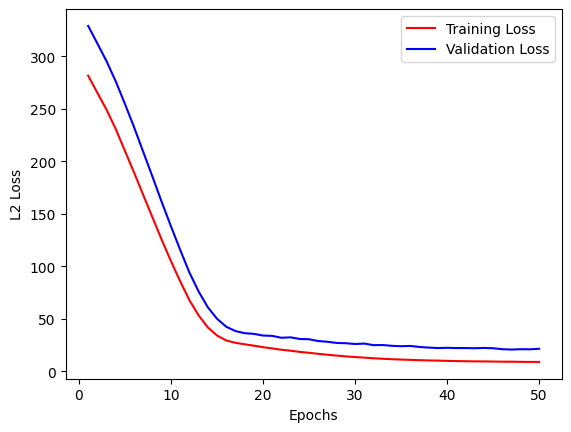


Training Loss :  8.791681412277331

Validation Loss :  21.32501596107805


In [9]:
# Define and train the Deep Neural Network.

model = Deep_Neural_Network()

model.create(2,1,[10,20],output_type='regression',activation='relu',initializer='he')

costs = model.train(X_train.T,Y_train,X_val.T,Y_val,optimizer='rmsprop',regularizer='l2',
                    regularizer_lambda=0.1,mini_batch_size=32,epochs=50,print_loss_freq=10,
                    learning_rate=0.002)

In [13]:
train_cost, val_cost, train_acc, val_acc = costs

In [10]:
dt = np.array([1.02237078, -1.12367874])

ds = np.array([[ 0.11934137,  2.51324773], [-0.65939625,  0.58604286]])

ds.shape



(2, 2)

In [99]:
X_train.shape

(363, 2)

In [98]:
hasil = model.predict(ds)

print(model.L)

print("hasil -> ", hasil)

3
hasil ->  [[23.39143561 33.74300449]]


In [36]:
Y_test

array([ 7.2, 18.8, 19. , 27. , 22.2, 24.5, 31.2, 22.9, 20.5, 23.2, 18.6,
       14.5, 17.8, 50. , 20.8, 24.3, 24.2, 19.8, 19.1, 22.7, 12. , 10.2,
       20. , 18.5, 20.9, 23. , 27.5, 30.1,  9.5, 22. , 21.2, 14.1, 33.1,
       23.4, 20.1,  7.4, 15.4, 23.8, 20.1, 24.5, 33. , 28.4, 14.1, 46.7,
       32.5, 29.6, 28.4, 19.8, 20.2, 25. , 35.4, 20.3,  9.7, 14.5, 34.9,
       26.6,  7.2, 50. , 32.4, 21.6, 29.8, 13.1, 27.5, 21.2, 23.1, 21.9,
       13. , 23.2,  8.1,  5.6, 21.7, 29.6, 19.6,  7. , 26.4, 18.9, 20.9,
       28.1, 35.4, 10.2, 24.3, 43.1, 17.6, 15.4, 16.2, 27.1, 21.4, 21.5,
       22.4, 25. , 16.6, 18.6, 22. , 42.8, 35.1, 21.5, 36. , 21.9, 24.1,
       50. , 26.7, 25. ])